**Students:** CHEN Eric, DESVOIX Florent

# SD-TSIA210 : Challenge

This report aims to briefly introduce a significant part of the algorithms we used, and the way we computed them. As our computers were not able to run those tasks, we ran our Python scripts on GPUs (gpu2.enst.fr) and on CPUs from the school. The pieces of code included in this report aim at understanding what we did.

## Imports

Some useful Python librairies we used to compute our predictions:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

Then we import our dataset. (`X_small`, `y_small`) is, as its name suggests, a small version of the dataset. We only use this version within the notebook. Obviously, the biggest one was used for our computations.

In [2]:
df_X = pd.read_csv('./data/xtrain_challenge.csv')
df_y = pd.read_csv('./data/ytrain_challenge.csv')

X = df_X.values
y = df_y.values

ind = sample(list(np.arange(0, len(X))), 10000)
X_small = X[ind]
y_small = y[ind]

## Introduction and visualization

During this challenge, we will do classification. Our dataset includes two classes: class 0 (not the same image) and class 1 (the same image). 

First, let's look at the distribution of data across these two classes.

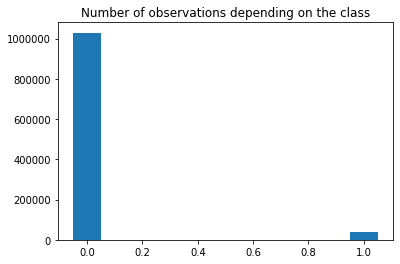

In [3]:
width = 0.1
plt.bar([0, 1], [len(y[y == 0]), len(y[y == 1])], width)
plt.title("Number of observations depending on the class")
plt.show()

In [4]:
print(f"% of samples from class 0 : {len(y[y == 0]) / len(y)}")
print(f"% of samples from class 1 : {len(y[y == 1]) / len(y)}")

% of samples from class 0 : 0.9629453890673315
% of samples from class 1 : 0.03705461093266848


As we can see, we are dealing with an imbalanced dataset, so we can suppose that we will have a majority of false negatives.

To better understand if an algorithm works, we will define a "universal" way to evaluate it. In particular, we will look carefully at the number of false negatives.

As our algorithms don't output the prediction in the same format, first, for each model, we will define a function, `predict`, which outputs the computations with the right format (a numpy array with 0 or 1).

Then, the following `score` function will use this function, so as to compute :
- the accuracy
- % of false positives
- % of false negatives
- the recall ($\frac{\text{TP}}{\text{TP} + \text{FP}}$)
- the specificity ($\frac{\text{TN}}{\text{TN} + \text{FP}}$)

In [5]:
def score(model_label, predict_function, X, y):
    y = y.flatten()
    n = len(y)
    y_pred = predict_function(X)
    errors = len(np.where(y_pred != y)[0])
    false_neg = len(np.where(y_pred - y == -1)[0])
    false_pos = len(np.where(y_pred - y == 1)[0])
    true_neg = len(y[np.logical_and(y == 0, y_pred == 0)])
    true_pos = len(y[np.logical_and(y == 1, y_pred == 1)])
    print(f"================ Model: {model_label} ================")
    print(f"Accuracy: {1 - errors / n}")
    print(f"% of false positives: {false_pos / errors}")
    print(f"% of false negatives: {false_neg / errors}")
    print(f"Recall: {true_pos / (true_pos + false_neg)}")
    print(f"Specificity: {true_neg / (true_neg + false_pos)}")

We will explain how we tuned the following models, and the issues we encountered:
- Perceptron
- SVM
- Neural Networks
- Random Forest
- XGBoosting
- Stacking
- Data augmentation

For each model, we will give the accuracy obtained on the test set (with the full dataset).

Let's split our dataset into train and test sets and normalize them.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_small,
                                                    y_small,
                                                    train_size=0.8)

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Perceptron

To start, let's look at what a simple algorithm like Perceptron can do. It is also the opportunity, to illustrate the approach we discussed.

In [8]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
predict = lambda X: perceptron.predict(X)
score("Perceptron", predict, X_test, y_test)

================ Model: Perceptron ================
Accuracy: 0.9985
% of false positives: 0.6666666666666666
% of false negatives: 0.3333333333333333
Recall: 0.9868421052631579
Specificity: 0.998960498960499


As expected, we have a "bad" recall, so our predictor badly classifies elements from class 1.

We will tune the model:
- our first idea was to add a class weight
- we will also try to find the best learning rate

In [10]:
class_weight = {0: 1, 1: 2}
perceptron = Perceptron(class_weight=class_weight)
perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight={0: 1, 1: 2}, early_stopping=False,
           eta0=1.0, fit_intercept=True, max_iter=1000, n_iter_no_change=5,
           n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
score("Perceptron", predict, X_test, y_test)

================ Model: Perceptron ================
Accuracy: 0.9975
% of false positives: 0.4
% of false negatives: 0.6
Recall: 0.9605263157894737
Specificity: 0.998960498960499


Here we improved our recall with class weights.

In [12]:
params = {
    'class_weight': [{0: 1, 1: (i / 10)} for i in range(10, 30)],
    'eta0': [(1 / 10**(i)) for i in range(1, 10)]
}

clf = GridSearchCV(perceptron, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Perceptron(alpha=0.0001, class_weight={0: 1, 1: 2},
                                  early_stopping=False, eta0=1.0,
                                  fit_intercept=True, max_iter=1000,
                                  n_iter_no_change=5, n_jobs=None, penalty=None,
                                  random_state=0, shuffle=True, tol=0.001,
                                  validation_fraction=0.1, verbose=0,
                                  warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [{0: 1,...
                                          {0: 1, 1: 1.2}, {0: 1, 1: 1.3},
                                          {0: 1, 1: 1.4}, {0: 1, 1: 1.5},
                                          {0: 1, 1: 1.6}, {0: 1, 1: 1.7},
                                          {0: 1, 1: 1.8}, {0: 1, 1: 1.9},
                                          {0: 1, 1: 2.0}, {0: 1, 1: 2.1},
         

In [13]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'class_weight': {0: 1, 1: 1.1}, 'eta0': 0.1}


But in practice, we obtain better results on the test set with class weight $(1, 2)$.

In [14]:
perceptron = Perceptron(
    class_weight={0: 1, 1: 2},
    eta0=0.01
)
perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight={0: 1, 1: 2}, early_stopping=False,
           eta0=0.01, fit_intercept=True, max_iter=1000, n_iter_no_change=5,
           n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
score("Perceptron", predict, X_test, y_test)

================ Model: Perceptron ================
Accuracy: 0.9975
% of false positives: 0.4
% of false negatives: 0.6
Recall: 0.9605263157894737
Specificity: 0.998960498960499


Finally, we ran this algorithm with the full dataset. We obtain the accuracy : ~**0.9973**

## Support Vector Machine (SVM)

We used the same approach for SVM.

In [16]:
svm = SVC()

params = {
    'kernel': ['linear', 'rbf'],
    'C': np.arange(1, 11),
    'class_weight': [{0: 1, 1: (i / 10)} for i in range(10, 30)]
}

clf = GridSearchCV(svm, params, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'class_...0: 1, 1: 1.0}, {0: 1, 1: 1.1},
                                          {0: 1, 1: 1.2}, {0: 1, 1: 1.3},
                                          {0: 1, 1: 1.4}, {0: 1, 1: 1.5},
                                          {0: 1, 1: 1.6}, {0: 1, 1: 1.7},
                                          {0: 1, 1: 1.8}, {0: 1, 1: 1.9},
                                          {0: 1, 1: 2.0}, {0: 1, 1: 2.1},
        

In [17]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'C': 2, 'class_weight': {0: 1, 1: 1.3}, 'kernel': 'rbf'}


In [18]:
svm = SVC(
    C=4,
    class_weight={0: 1, 1: 2},
    kernel='rbf'
)

svm.fit(X_train, y_train)

SVC(C=4, break_ties=False, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
predict = lambda X: svm.predict(X)
score("SVM", predict, X_test, y_test)

================ Model: SVM ================
Accuracy: 0.998
% of false positives: 0.0
% of false negatives: 1.0
Recall: 0.9473684210526315
Specificity: 1.0


We can make the same remark: in practice, we obtain better results when we set class weight to 2.
The accuracy is: ~**0.9980**

## Neural Networks

First, it was difficult to have an intuition to design the right neural network, so we made a lot of tests. The template we used is the following (inspired by the lab sessions and a Keras' tutorial):

- First, we define our model in the following function:

In [20]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model(X_train, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            16, activation='relu',
            input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(
            8, activation='relu',
            input_shape=(16,)),
        tf.keras.layers.Dense(
            1, activation='sigmoid',
            bias_initializer=output_bias)
      ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

- Then, we run it.

In [21]:
EPOCHS = 100
BATCH_SIZE = 1024

neg, pos = np.bincount(df_y['y'])
total = neg + pos
weight_for_0 = (1 / neg) * (total) / 2.0 
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
initial_bias = np.log([pos / neg])

model = make_model(X_train, output_bias=initial_bias)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    verbose=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In this example, we designed a 3 layers neural network. The first layers use relu activation function, and the last one the sigmoid, so as to output a "probability", $P(y = 1)$.

As for last models, to deal with our imbalanced dataset, we define a class weight. We tried the one above, but in practice (again), $(1, 2)$ seems better.

We also set an initial bias, which enables to accelerate the convergence.

We tried to set a kind of compromise between the number of epochs and the batch size.

The results we obtained in terms of accuracy on the test set were not astonishing with neural networks. Moreover, it was difficult to run those algorithms efficiently, so we ran them on *gpu2.enst.fr*.

The best accuracy we obtained (with the whole dataset) was: **0.997879634608**.

We paid particular attention to the history curb. Unfortunatly, as our computation were made on GPUs, we are not able to display those curbs properly, but here is an example of what it looks like:

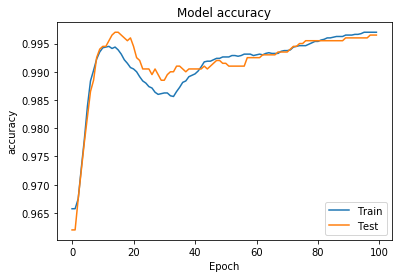

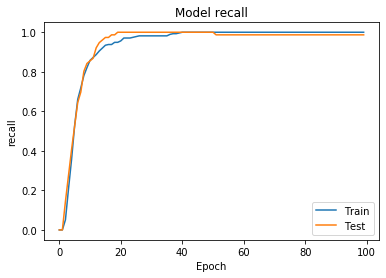

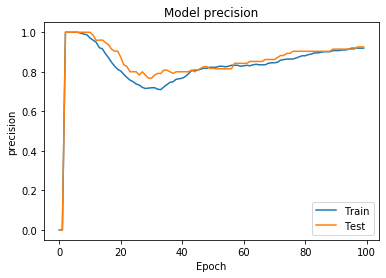

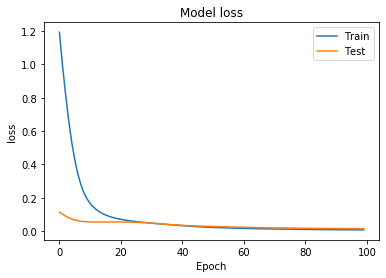

In [22]:
def plot(param):
    plt.plot(history.history[param])
    plt.plot(history.history[f'val_{param}'])
    plt.title(f'Model {param}')
    plt.ylabel(param)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

plot('accuracy')
plot('recall')
plot('precision')
plot('loss')

Here the only thing we can observe is that our model is still learning.

- Finally we tried to set the best threshold and then we output our results. Here we set it to 0.8.

In [23]:
thresh = lambda X: np.array([1 * (x[0] > 0.8) for x in X])
predict = lambda X: thresh(model.predict(X))

In [24]:
score('3 layers Neural Network', predict, X_test, y_test)

================ Model: 3 layers Neural Network ================
Accuracy: 0.998
% of false positives: 0.5
% of false negatives: 0.5
Recall: 0.9736842105263158
Specificity: 0.998960498960499


## Random Forest

The Random Forest Classifier is an ensemble tree-based learning algorithm. It aggregates the votes from different decision trees to decide the final class of the test object. We expect this model to have better results than the previous ones because a large number of relatively uncorrelated models (trees) operating as a committee should be able to outperform any of the individual constituent models. One reason for this statement is the low correlation between models as a random forest consists of multiple random decision trees.

In [9]:
rf = RandomForestClassifier()
params = {
    'n_estimators': np.array([100, 200, 300, 400, 500]),
    'max_depth': np.arange(5,15)
}

clf = GridSearchCV(rf, params, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [10]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'max_depth': 9, 'n_estimators': 200}


In [15]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=9,
)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
predict = lambda X: rf.predict(X)
score("Random Forest", predict, X_test, y_test)

================ Model: Random Forest ================
Accuracy: 0.9965
% of false positives: 0.2857142857142857
% of false negatives: 0.7142857142857143
Recall: 0.9479166666666666
Specificity: 0.9989495798319328


The best accuracy we obtained (with the whole dataset) was: **~0.9984**.

Our expectations have been fulfilled for the Random Forest Classifier. We note that the proportion of false positives and negatives is fairly low. Furthermore, we observe that the results are quite stable, which could be an interesting attribute of ensemble methods.

## XGBoosting

Now that we've seen that an ensemble tree-based learning algorithm have interesting results, with the example of Random Forest Classifier, we can continue on this path by trying to use Gradient Boosting in order to minimize errors.  In this case, we have decided to use, instead of a simple Gradient Boosting algorithm, the XGBoosting algorithm. It can be seen as an improved version of Gradient Boosting, which focuses on execution speed and model performance.  

We have chosen 'binary logistic' as an objective function which refers to logistic regression for binary classification, and the output will the probability for each element of the training set to be labeled as 1.
Consequently, a threshold is applied on the output probability in order to label our data.

In [17]:
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
)
params = {
    'max_depth': np.arange(8,12),
    'colsample_bytree': np.array([0.6, 0.7, 0.8]),
    'learning_rate': np.array([0.1, 0.01]),
    'alpha': np.arange(0,5)
}

clf = GridSearchCV(model, params, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='warn', n_jobs=None,
             para

In [18]:
print(f'Best parameters:\n{clf.best_params_}')

Best parameters:
{'alpha': 0, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8}


With the whole dataset, the best parameters are actually **max_depth = 9, colsample_by_tree = 0.7 and alpha = 1**  

In [24]:
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    max_depth=9,
    colsample_bytree=0.7,
    alpha=1,
    learning_rate=0.01
)

model.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [25]:
predict = lambda X: model.predict(X)
score("XGBoosting", predict, X_test, y_test)

================ Model: XGBoosting ================
Accuracy: 0.995
% of false positives: 0.4
% of false negatives: 0.6
Recall: 0.9375
Specificity: 0.9978991596638656


The best accuracy we obtained (with the whole dataset) was: **0.998598678358**. 

We can observe that XGBoosting gives better results than Random Forest with the whole dataset. Indeed, it is a gradient boosting decision tree algorithm, where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. Furthermore, XGBoost stands for eXtreme Gradient Boosting. Thus, it is an enhanced version of Gradient Boosting. 

## Stacking

We also found an interesting ensemble method : *stacking*. It consists of using different machine learning models in order to predict our class value. It could be relevant to compute it, as we obtain good accuracy with our previous models.

A first natural choice was to use all of them (and in practice, it was the most efficient).

In [35]:
xgboosting = XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=9,
    alpha=1,
    n_estimators=1000)

perceptron = Perceptron(
    class_weight={0: 1, 1: 2},
    eta0=0.01
)

svm = SVC(
    C=4,
    class_weight={0: 1, 1: 2},
    kernel='rbf'
)

random_forest = RandomForestClassifier(
    class_weight={0: 1, 1: 2},
    n_estimators=100,
    max_depth=8,
    random_state=0
)

estimators = [
    ('xgboosting', xgboosting),
    ('Perceptron', perceptron),
    ('SVM', svm),
    ('Random Forest', random_forest)
]

model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

model.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('xgboosting',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=9,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=...
                          

In [38]:
predict = lambda X: model.predict(X)
score('Stacking', predict, X_test, y_test)

================ Model: Stacking ================
Accuracy: 0.9985
% of false positives: 0.3333333333333333
% of false negatives: 0.6666666666666666
Recall: 0.9736842105263158
Specificity: 0.9994802494802495


With this model, we obtain our best accuracy on the test set: **0.998619170803**

## Data augmentation

After some research about the way we could face the issue of imbalanced data, we thought about augmenting our minority class (class 1). A great Python library to do it is imblearn: we used some oversampling method called SMOTE (Synthetic Minority Over-Sampling TEchnique), applied to our previous initial models (obviously, we removed the class weights $(1, 2)$).

We just have to apply this preprocessing method, and re-run our algorithms.

In [42]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [45]:
counts = np.bincount(y_train_res.flatten())
print(f'Samples from class 0: {counts[0]}')
print(f'Samples from class 1: {counts[1]}')

Samples from class 0: 7726
Samples from class 1: 7726


We tried it on the following methods (amongst others):
- XGBoosting (accuracy: ~**0.9985**)
- Stacking XGBoosting/RandomForest/Perceptron (accuracy: ~**0.9984**)
- Stacking SVM/RandomForest/Perceptron/XGBoosting (accuracy: ~**0.9984**)

It was not as successful as expected. It seems that we have too much data from class 1. Maybe we could have had a class_weight so as to penalize false positives, or train our model with less samples from class 1 (for example: 30% with label 1 - 70% with label 0), but as the computations were long, we did not have sufficient time to re-train it another time.

## Conclusion

It was an interesting challenge and a great opportunity to deal with an imbalanced dataset (we believe that it was the main issue), which is a concrete and ubiquitous problem among machine learning.

We experienced many methods studied during the lectures and discovered new ones. We saw how pre-processing is important, and also that most of the time, ensemble methods are more stable.